# Fit BAO peak from input correlation function

In [108]:
import numpy as np

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

from pycorr import TwoPointCorrelationFunction, TwoPointEstimator, NaturalTwoPointEstimator, project_to_multipoles, project_to_wp, utils, setup_logging
from cosmoprimo import *

from densitysplit import catalog_data, density_split
from bin.density_split_mocks_functions import split_density, compute_densitySplit_CCF
from densitysplit.pk_model import *
from densitysplit.utils import *
from densitysplit.corr_func import *

# To activate logging
setup_logging()

## Data and output directories

In [2]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Get data

In [3]:
#catalog_name = 'AbacusSummit_1Gpc_z1.175'
#bias = 1.8

catalog_name = 'AbacusSummit_2Gpc_z1.175'
#bias = 3.

#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog = catalog_data.Data.load(data_dir+catalog_name+'.npy')
catalog.shift_boxcenter(-catalog.offset)

In [4]:
z = catalog.redshift

# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()
f = bg.Omega_m(z)**0.55

## Load correlation function poles

In [5]:
ells = [0]
nells = len(ells)

### 2PCF

In [6]:
mocks_results = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_1000_mocks_2PCF.npy', allow_pickle=True)

_, cov = get_poles(mocks_results, ells)

## Pull test

In [7]:
def bao_fit(s, xiell, ells, cov):
    pk_model = PkModel(sep=s, ells=ells, xiell=xiell, cov=cov, redshift=z, cosmology=cosmo_abacus, k=np.logspace(-3,2,1000), split=False)
    pk_model.set_pk_model()
    default_params = {'f': 0., 'b': 2., 'alpha_par': 1., 'alpha_perp': 1., 'sigma_par': 5., 'sigma_perp': 5., 'sigma_s': 0.}
    pk_model.set_default_params(**default_params)

    # Remove small scales (linear model not valid at small scales)
    s_lower_limit = 50 # Mpc/h

    # initialize parameters
    broadband_coeffs = np.tile([0., 0., 0.], nells)
    params_init = {'b': 2., 'alpha_par': 1., 'sigma_par': 5., 'broadband_coeffs': broadband_coeffs}

    popt, pcov = pk_model.fit(fit_params_init=params_init, s_lower_limit=s_lower_limit, print_output=False)
    
    return popt, pcov

In [8]:
alphas = list()
alphas_err = list()

from tqdm.notebook import tqdm

for result in tqdm(mocks_results):
    s, xiell = result.get_corr(ells=ells, return_sep=True)
    
    popt, pcov = bao_fit(s, xiell, ells, cov)
    alpha_index = np.argwhere(np.array(list(popt.keys())) == 'alpha_par')[0][0]
    std = np.diag(pcov)**0.5
    alpha_err = std[alpha_index]
    
    alphas.append(popt['alpha_par'])
    alphas_err.append(alpha_err)

  0%|          | 0/1000 [00:00<?, ?it/s]

/feynman/work/dphp/adematti/cosmodesiconda/20220419-1.0.0/conda/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [11]:
alphas_arr = np.array(alphas)
alphas_err_arr = np.array(alphas_err)

In [24]:
np.save(output_dir+'pull_test_alphas', alphas_arr)
np.save(output_dir+'pull_test_alphas_errors', alphas_err_arr)

In [12]:
test = (alphas_arr - np.mean(alphas_arr)) / alphas_err_arr

In [84]:
from scipy.stats import norm

(mu, sigma) = norm.fit(test)

In [85]:
print(mu)
print(sigma)

-0.017416760504959876
1.0073268083291667


In [86]:
x = np.linspace(-3, 3, 50)
model = norm.pdf(x, mu, sigma)

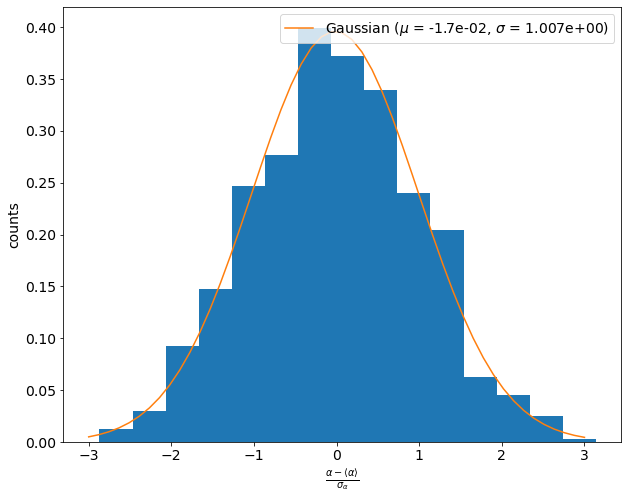

In [112]:
plt.hist(test, bins=15, density=True)
plt.plot(x, model, label=r'Gaussian ($\mu$ = {:.1e}, $\sigma$ = {:.3e})'.format(mu, sigma))
plt.xlabel(r'$\frac{\alpha - \langle \alpha \rangle}{\sigma_{\alpha}}$')
plt.ylabel('counts')
plt.legend()
plt.show()